In [2]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,plot_outline,plot_dendrogram,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [4]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is graph of median topologies and dendrogram cluster graph
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,1,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=4
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
# generate holder for dataframes for looping 

if loud[2]:
    a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
    plt.scatter(a["Pc1"],a["Pc2"])
    color = AgglomerativeClustering(n_clusters=g_comp).fit_predict(a)
    #color=gm.predict(a)
    plt.scatter(a["Pc1"],a["Pc2"],c=color)
    plt.legend()
    plot_outline(abridge)


    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(a)
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model,a, truncate_mode="level", p=3)
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
model = AgglomerativeClustering(n_clusters=g_comp)
model = model.fit(a)
model.labels_
dic={}
for a,b in zip(a.index,model.labels_):
    dic[a]=b
abridge["t_cluster"]=abridge["topology"].map(dic)
O_M_Cluster=[]
for i in sorted(abridge["t_cluster"].unique()):
    Temp=abridge[abridge["t_cluster"]==i]
    O_M_Cluster.append(Temp)

# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
resize=False
if resize:
    M_Cluster=size_clusters(O_M_Cluster)
else:
    M_Cluster=O_M_Cluster
#Base Cluster for transfer learning 
#specify cluster
cluster=0
data = M_Cluster[0]
#checks for index problem
data = data.reset_index(drop=True)
#computer requirements 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()

features = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
#create splits 
df_train,df_val,df_test=prep_data_splits(data,features,interest)
#create dataset loader objects for looping through data,default test size is .2
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
#intialize holders for data
train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []

# initalize model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
learning_rate = trial_parameters["lr"]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Create engine for running NN, pytorch

def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
#sets up loss and R scores and stores values
#Note: note sure if can condense this into a module b/c of decorator and namespace
@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    if loud[2]:
        print(e)
#Creates timer and runs trainer 
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
plt.show()

if loud[3]:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
#save base model for transfer into other clusters in loop
torch.save(model, "Temp.ckpt")
#transfer learning part
#stores meta data
test_loss_holder=[]
test_r2_holder=[]
#loops through clusters
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    #loading model again
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
#turns off model learning
    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    #Base Cluster for transfer learning 
    data = i
    #checks for index problem
    data = data.reset_index(drop=True)
    #splits data set
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    #once again making training and testing engine
    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[4]:
            print(e)
    #runs model
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
#plots all clusers learning in terms of test set
if loud[5]:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_47760/182450929.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["t_cluster"]=abridge["topology"].map(dic)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWar

KeyboardInterrupt: 

In [4]:
for i in M_Cluster:
    print(len(i))
    number=i["t_cluster"].unique()
    print(i["topology"].unique(),f"Cluster {number[0]}")

5422
['bor' 'crs' 'csq' 'ctn' 'rhrb' 'sodb' 'spn' 'srsb' 'ssa' 'stp' 'tbo'
 'the' 'tpt'] Cluster 0
3288
['acs' 'flu' 'ftw' 'gar' 'lvtb' 'nia' 'ocu' 'pcu' 'reo' 'rht' 'scu'] Cluster 1
4235
['diab' 'iac' 'lcsb' 'nbob' 'pth' 'pto' 'pts' 'pyr' 'qtz' 'she' 'soc'
 'ssb'] Cluster 2
561
['bcs' 'bct' 'bcu' 'fcu' 'ith'] Cluster 3


/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_47760/726575575.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["t_cluster"]=abridge["topology"].map(dic)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWar

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


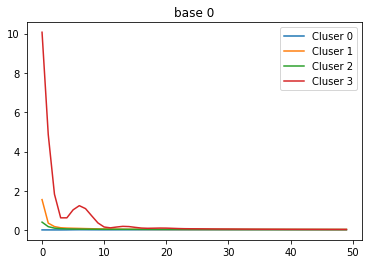

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

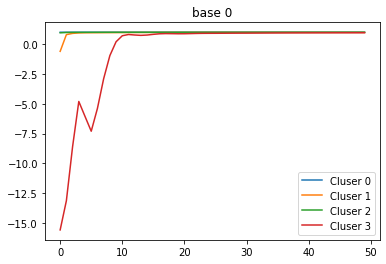

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


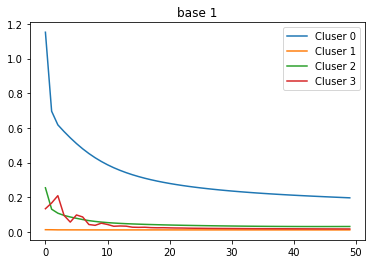

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

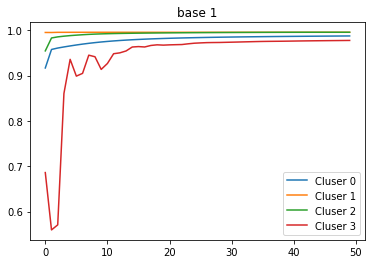

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


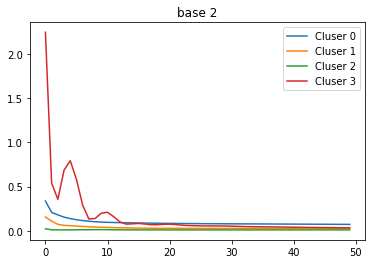

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

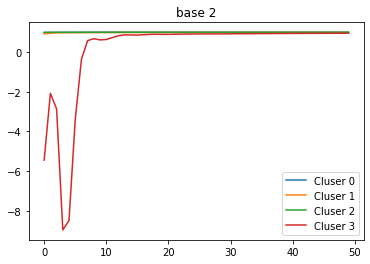

/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
1


/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
/Users/gregcooper/Desktop/Research/TL_MOF/Functions/Statistics_helper.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
/Users/gregcooper/

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


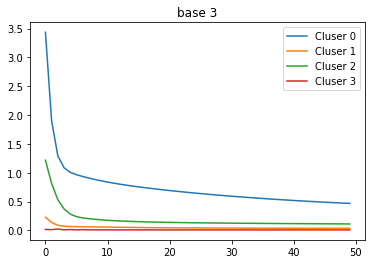

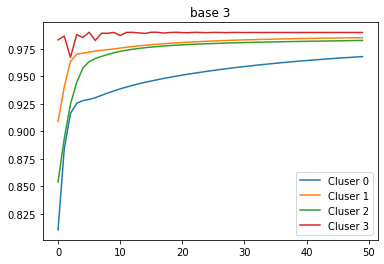

In [31]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is graph of median topologies and dendrogram cluster graph
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,1,1,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=4
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
# generate holder for dataframes for looping 

if loud[2]:
    a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
    plt.scatter(a["Pc1"],a["Pc2"])
    color = AgglomerativeClustering(n_clusters=g_comp).fit_predict(a)
    #color=gm.predict(a)
    plt.scatter(a["Pc1"],a["Pc2"],c=color)
    plt.legend()
    plot_outline(abridge)


    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(a)
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model,a, truncate_mode="level", p=3)
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
model = AgglomerativeClustering(n_clusters=g_comp)
model = model.fit(a)
model.labels_
dic={}
for a,b in zip(a.index,model.labels_):
    dic[a]=b
abridge["t_cluster"]=abridge["topology"].map(dic)
O_M_Cluster=[]
for i in sorted(abridge["t_cluster"].unique()):
    Temp=abridge[abridge["t_cluster"]==i]
    O_M_Cluster.append(Temp)

# parameters for neural net
epochs = 500
epochs=50
batch_size = 128
input_size = 5
output_size = 1
resolution=50
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
resize=False
#specify cluster
#meta_trials=100
#meta=[]
#for i in range(meta_trials):
    #create holder for meta anaylsis
mega={}
for i in range(len(M_Cluster)):
    mega[i]=[]
if resize:
    M_Cluster=size_clusters(O_M_Cluster)
else:
    M_Cluster=O_M_Cluster
for count,g in enumerate(M_Cluster):
    cluster=count
    data = g
    #checks for index problem
    data = data.reset_index(drop=True)
    #computer requirements 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = os.getcwd()

    features = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
    #create splits 
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
    #intialize holders for data
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []

    # initalize model
    model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
    criterion = nn.MSELoss()
    learning_rate = trial_parameters["lr"]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #Create engine for running NN, pytorch

    def train_step(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()

    trainer = Engine(train_step)
    #sets up loss and R scores and stores values
    #Note: note sure if can condense this into a module b/c of decorator and namespace
    @trainer.on(Events.EPOCH_COMPLETED(every=50))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[2]:
            print(e)
    #Creates timer and runs trainer 
    start = time.time()
    trainer.logger.disabled=True
    trainer.run(train_loader, max_epochs=epochs)
    plt.show()

    if loud[3]:
        plt.plot(val_r_2)
        plt.plot(train_r_2,label="t")
        plt.plot(test_r_2,label="real")
        plt.legend()
        plt.show()
        plt.plot(val_loss)
        plt.plot(train_loss,label="t")
        plt.plot(test_loss,label="real")
        plt.legend()
        plt.show()
    #save base model for transfer into other clusters in loop
    torch.save(model, "Temp.ckpt")
    #transfer learning part
    #stores meta data
    test_loss_holder=[]
    test_r2_holder=[]
    #loops through clusters
    for count,i in enumerate(M_Cluster):
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []
        #loading model again
        model=torch.load("Temp.ckpt")
        descriptor_columns = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
    #turns off model learning
        model.fc1.weight.requires_grad = False
        model.fc1.bias.requires_grad = False
        model.fc2.weight.requires_grad = False
        model.fc2.bias.requires_grad = False

        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
        )
        #Base Cluster for transfer learning 
        data = i
        #checks for index problem
        data = data.reset_index(drop=True)
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

        #once again making training and testing engine
        def train_step_1(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()


        transfer_trainer = Engine(train_step_1)
        n=int(epochs/resolution)
        @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[4]:
                print(e)
        #runs model
        transfer_trainer.logger.disabled=True
        transfer_trainer.run(train_loader, max_epochs=epochs)
        test_loss_holder.append(test_loss)
        test_r2_holder.append(test_r_2)
    #because error tends to be low, only anaylizing r2 scores
        mega[count].append(test_r_2)
    #plots all clusers learning in terms of test set
    if loud[5]:
        plt.title(f"base {cluster}")
        for count,i in enumerate(test_loss_holder):
            plt.plot(i,label=f"Cluser {count}")
        plt.legend()
        plt.show()
        plt.title(f"base {cluster}")
        for count,i in enumerate(test_r2_holder):
            plt.plot(i,label=f"Cluser {count}")
        plt.legend()
    #meta.append(mega)

In [23]:
for i in range(4):
    display(abridge[abridge["t_cluster"]==i].groupby("topology").count())

,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/243K (wt%),Pc1,Pc2,Cluster,t_cluster
topology,,,,,,,,,,,
bor,474,474,474,474,474,474,474,474,474,474,474
crs,47,47,47,47,47,47,47,47,47,47,47
csq,611,611,611,611,611,611,611,611,611,611,611
ctn,473,473,473,473,473,473,473,473,473,473,473
rhrb,512,512,512,512,512,512,512,512,512,512,512
sodb,420,420,420,420,420,420,420,420,420,420,420
spn,288,288,288,288,288,288,288,288,288,288,288
srsb,528,528,528,528,528,528,528,528,528,528,528
ssa,150,150,150,150,150,150,150,150,150,150,150


,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/243K (wt%),Pc1,Pc2,Cluster,t_cluster
topology,,,,,,,,,,,
acs,47,47,47,47,47,47,47,47,47,47,47
flu,701,701,701,701,701,701,701,701,701,701,701
ftw,288,288,288,288,288,288,288,288,288,288,288
gar,384,384,384,384,384,384,384,384,384,384,384
lvtb,528,528,528,528,528,528,528,528,528,528,528
nia,48,48,48,48,48,48,48,48,48,48,48
ocu,288,288,288,288,288,288,288,288,288,288,288
pcu,47,47,47,47,47,47,47,47,47,47,47
reo,141,141,141,141,141,141,141,141,141,141,141


,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/243K (wt%),Pc1,Pc2,Cluster,t_cluster
topology,,,,,,,,,,,
diab,420,420,420,420,420,420,420,420,420,420,420
iac,192,192,192,192,192,192,192,192,192,192,192
lcsb,420,420,420,420,420,420,420,420,420,420,420
nbob,528,528,528,528,528,528,528,528,528,528,528
pth,474,474,474,474,474,474,474,474,474,474,474
pto,528,528,528,528,528,528,528,528,528,528,528
pts,474,474,474,474,474,474,474,474,474,474,474
pyr,288,288,288,288,288,288,288,288,288,288,288
qtz,47,47,47,47,47,47,47,47,47,47,47


,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/243K (wt%),Pc1,Pc2,Cluster,t_cluster
topology,,,,,,,,,,,
bcs,93,93,93,93,93,93,93,93,93,93,93
bct,47,47,47,47,47,47,47,47,47,47,47
bcu,141,141,141,141,141,141,141,141,141,141,141
fcu,47,47,47,47,47,47,47,47,47,47,47
ith,233,233,233,233,233,233,233,233,233,233,233


In [28]:
len(M_Cluster)

6

In [34]:

anaylsis(mega)

TypeError: anaylsis() got an unexpected keyword argument 'n'